# Set-up

In [1]:
# Import libraries

# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline  # Same, but with the latter it is not necessary to name estimator and transformer
#from imblearn.pipeline import Pipeline as Imb_Pipe
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, GenericUnivariateSelect, mutual_info_classif
import eli5

# Predictive Modeling (Models)
from sklearn.dummy import DummyClassifier, DummyRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveRegressor, ElasticNet, SGDRegressor, RANSACRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, VotingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, fbeta_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, precision_score
from scipy.sparse import csr_matrix

# Neural Networks
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# Import data_engineered
data = pd.read_pickle("saves/data_engineered.pkl")

In [3]:
# Alternative: Import from csv
#data_types_engineered = pd.read_csv('saves/types_engineered.csv')['types']
#data = pd.read_csv("saves/data_engineered.csv", dtype=data_types_engineered.to_dict())
#data.set_index('id', inplace=True)

In [4]:
# Dashboard
target = 'occupancy_class'  # for regression: 'occupancy_rate', 'price_log' | for classification: 'occupancy_class'
drop_cols = [
    'occupancy_rate'
]  # additional columns to drop: 'occupancy_class', 'occupancy_rate'
scoring = 'f1'  # for regression: 'neg_mean_squared_error', 'r2', 'neg_mean_poisson_deviance', 'neg_median_absolute_error' | for classification: "f1", "recall", "precision", "accuracy", "roc_auc"
test_size = 0.2
random_state = 42

# Preprocessing (Train/Test Split and Pipeline)

In [5]:
# Drop columns
data = data.drop(drop_cols, axis=1)

In [ ]:
# Drop rows
data = data[data.room_type != "shared_room"]

## Preprocessing pipeline

In [6]:
# Create list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline")
cat_features = list(data.columns[data.dtypes == object])
#cat_features.remove("neighbourhood")
#cat_features.remove("zipcode")
cat_features

['cancellation_policy',
 'neighbourhood',
 'property_type',
 'room_type',
 'zipcode']

In [7]:
# Create list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(data.columns[data.dtypes != object])
num_features.remove(target)
num_features

['accommodates',
 'accommodates_per_bed',
 'am_balcony',
 'am_breakfast',
 'am_child_friendly',
 'am_elevator',
 'am_essentials',
 'am_nature_and_views',
 'am_pets_allowed',
 'am_private_entrance',
 'am_smoking_allowed',
 'am_tv',
 'am_white_goods',
 'availability_90',
 'bathrooms_log',
 'bedrooms',
 'calculated_host_listings_count',
 'first_review_days',
 'host_is_superhost',
 'instant_bookable',
 'last_review_days',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights_log',
 'price_extra_fees_sqrt',
 'price_extra_people',
 'price_log',
 'review_scores_rating_sqrt',
 'text_len_sqrt',
 'wk_mth_discount']

In [8]:
# Build preprocessor pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([('imputer_num', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler())])

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(drop='first', handle_unknown='error'))
])

# Complete pipeline
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),
                                  ('cat', cat_pipeline, cat_features)])

In [9]:
# Function for getting column names after preprocessing
def get_column_names_from_ColumnTransformer(column_transformer):
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:
                                                                   -1]:  #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:  # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

## Train/test split

In [10]:
# Define predictors and target variable
X = data.drop([target], axis=1)
y = data[target]

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=True)
#                                                   stratify=y) # Use stratify=y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

In [12]:
# Saving preprocessed X_train and X_test
X_train_prep_preprocessor = preprocessor.fit(X_train)
X_train_prep_cols = get_column_names_from_ColumnTransformer(
    X_train_prep_preprocessor)

X_train_prep = X_train_prep_preprocessor.transform(X_train)
X_train_num_prep = num_pipeline.fit_transform(X_train[num_features])
X_test_prep = X_train_prep_preprocessor.transform(X_test)

## Outlier Detection

In [13]:
# Preprocess data
#train_outl = num_pipeline.fit_transform(X_train[num_features], y_train)

In [14]:
# Fit DBSCAN model
#outl_model = DBSCAN(eps=3.0, min_samples=10).fit(train_outl)
#outl_labels = outl_model.labels_

In [15]:
# Display results (# of outliers)
#pd.Series(outl_labels).value_counts()

In [16]:
# Illustrate results
#plt.figure(figsize=(10,10))
#
#unique_labels = set(outl_labels)
#colors = ['blue', 'red']
#
#for color,label in zip(colors, unique_labels):
#    sample_mask = [True if l == label else False for l in outl_labels]
#    plt.plot(train_outl[:,0][sample_mask], train_outl[:, 1][sample_mask], 'o', color=color);
#plt.xlabel('accommodates_per_bed');
#plt.ylabel('accommodates_per_room');

Interpreting the results:

- https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate
- https://datascience.stackexchange.com/questions/46092/how-do-we-interpret-the-outputs-of-dbscan-clustering

## Perform Feature Selection (add most useful to modeling pipeline)

In [17]:
# Set X_fs to desired variable
X_fs = X_train[
    num_features]  # X_train_prep, X_train_num_prep, X_train[num_features]
#X_fs = pd.DataFrame(X_fs, columns = X_train_prep_cols)

**GenericUnivariateSelect** (Classification and Regression)

In [18]:
# Apply GenericUnivariateSelect
trans_GUS = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0),
                                    mode='k_best',
                                    param=15)  #mode='percentile', 'k_best'
X_train_GUS = trans_GUS.fit_transform(X_fs, y_train)

**mutual_info_classif** (Classification)

In [19]:
# Fit mutual_info_classif
X_train_mic = mutual_info_classif(X_fs, y_train)

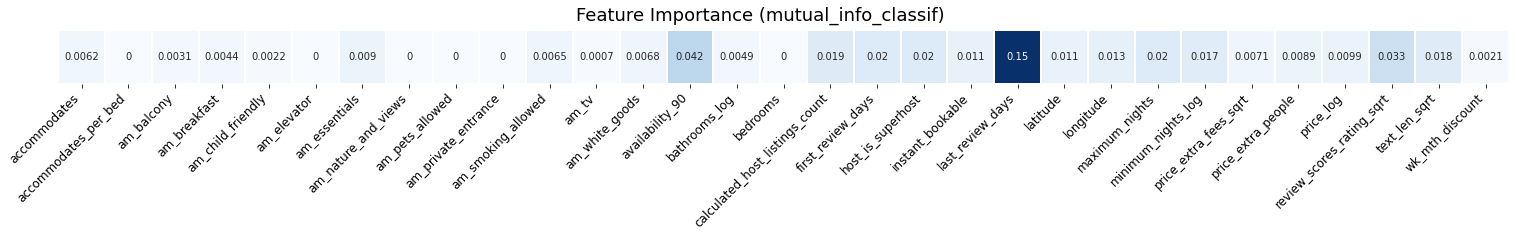

In [20]:
# Plot feature importance
plt.subplots(1, figsize=(26, 1))
sns.heatmap(X_train_mic[:, np.newaxis].T,
            cmap='Blues',
            cbar=False,
            linewidths=1,
            annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X_fs.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("Feature Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [21]:
# Apply GenericUnivariateSelect to reduce features (optional)
trans_mic = GenericUnivariateSelect(score_func=mutual_info_classif,
                                    mode='k_best',
                                    param=15)  #mode='percentile', 'k_best',
X_train_mic_GUS = trans_mic.fit_transform(X_fs, y_train)

In [22]:
# Print kept features
print("We started with {0} features but retained only {1} of them!".format(
    X_fs.shape[1] - 1, X_train_mic_GUS.shape[1]))

columns_retained_Select = X_fs.columns[trans_mic.get_support()].values
pd.DataFrame(X_train_mic_GUS, columns=columns_retained_Select).head()

We started with 30 features but retained only 15 of them!


,accommodates,am_white_goods,availability_90,calculated_host_listings_count,first_review_days,host_is_superhost,instant_bookable,last_review_days,latitude,longitude,maximum_nights,minimum_nights_log,price_extra_fees_sqrt,review_scores_rating_sqrt,text_len_sqrt
0,2.0,1.0,0.0,1.0,209.0,1.0,1.0,49.0,52.49772,13.47841,7.0,1.000000,3.000000,7.530058,0.067641
1,2.0,1.0,0.0,1.0,105.0,0.0,1.0,79.0,52.51983,13.30225,29.0,1.732051,0.000000,3.748119,0.427670
2,2.0,1.0,69.0,1.0,75.0,0.0,0.0,16.0,52.50498,13.31578,1125.0,1.414214,0.000000,8.944272,0.305561
3,2.0,1.0,11.0,1.0,80.0,0.0,1.0,20.0,52.52299,13.41016,1125.0,1.000000,0.000000,5.627647,0.518208
4,3.0,1.0,0.0,19.0,1118.0,0.0,0.0,273.0,52.53618,13.18963,183.0,5.477226,15.811388,8.944272,0.558772


**chi2** (Classification)

**mutual_info_regression** (Regression)

# Predictive Modeling: Classification ("occupancy_class")

## Apply Classification Models

In [23]:
# Print current setting for TARGET
target_upper = target.upper()
y_upper = y_train.name.upper()
print("You are currently using " + f"\033[1m{target_upper}\033[0m" +
      " as the target")
print("The target variable y is currently set to " +
      f"\033[1m{y_upper}\033[0m")

You are currently using OCCUPANCY_CLASS as the target
The target variable y is currently set to OCCUPANCY_CLASS


In [24]:
# Select dataset to use
#X_train = X_train_mic_GUS_red       # X_train, X_train_GUS, X_train_mic, ...

In [25]:
# Select models for comparison
models = {
    'Baseline':
    DummyClassifier(strategy='most_frequent'),
    'LogReg':
    LogisticRegression(max_iter=1000),
    'KNN':
    KNeighborsClassifier(),
    'SVC':
    SVC(kernel='rbf', C=1E6),
    'Decision Tree':
    DecisionTreeClassifier(criterion="gini",
                           max_depth=3,
                           random_state=random_state),
    'Random Forest':
    RandomForestClassifier(random_state=random_state,
                           max_features='sqrt',
                           n_jobs=-1),
    'Gradient Boost':
    GradientBoostingClassifier(random_state=random_state),
    'XGBoost':
    XGBClassifier(),
    'AdaBoost':
    AdaBoostClassifier(random_state=random_state)
}

In [26]:
# Calculate and display results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])
i = 0
for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipe,
                                     X_train,
                                     y_train.values.ravel(),
                                     cv=5,
                                     verbose=4,
                                     n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'MSE': mean_squared_error(y_train, y_train_pred),
            'RMSE': mean_squared_error(y_train, y_train_pred, squared=False),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'R2': r2_score(y_train, y_train_pred),
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred, average="weighted"),
            'Precision': precision_score(
                y_train, y_train_pred, average="weighted"),
            'F1 Score': f1_score(y_train, y_train_pred, average="weighted")
        },
        index=[i])
    print(f"Confusion Matrix {m[0]}: \n" +
          str(confusion_matrix(y_train, y_train_pred)))
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Baseline: 
[[6000    0]
 [2554    0]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix LogReg: 
[[5243  757]
 [ 925 1629]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix KNN: 
[[5071  929]
 [1292 1262]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix SVC: 
[[5088  912]
 [ 986 1568]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Confusion Matrix Decision Tree: 
[[4924 1076]
 [ 647 1907]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Random Forest: 
[[5588  412]
 [1171 1383]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Gradient Boost: 
[[5321  679]
 [ 763 1791]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix XGBoost: 
[[5307  693]
 [ 735 1819]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s


Confusion Matrix AdaBoost: 
[[5264  736]
 [ 770 1784]]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


,Model,MSE,RMSE,R2,MAE,Accuracy,Recall,Precision,F1 Score
0,Baseline,0.298574,0.546419,-0.425667,0.298574,0.701426,0.701426,0.491999,0.578337
1,LogReg,0.196633,0.443433,0.061092,0.196633,0.803367,0.803367,0.800081,0.801381
2,KNN,0.259645,0.509553,-0.239783,0.259645,0.740355,0.740355,0.730979,0.734236
3,SVC,0.221884,0.471046,-0.059481,0.221884,0.778116,0.778116,0.776339,0.777165
4,Decision Tree,0.201426,0.448805,0.038205,0.201426,0.798574,0.798574,0.810840,0.802643
5,Random Forest,0.185060,0.430186,0.116355,0.185060,0.814940,0.814940,0.809947,0.804296
6,Gradient Boost,0.168576,0.410580,0.195062,0.168576,0.831424,0.831424,0.829956,0.830601
7,XGBoost,0.166939,0.408582,0.202877,0.166939,0.833061,0.833061,0.832303,0.832660
8,AdaBoost,0.176058,0.419593,0.159337,0.176058,0.823942,0.823942,0.823288,0.823601


## Clf Model 1: LogReg

In [30]:
# Create pipeline to use in RandomSearchCV and GridSearchCV
pipeline_lr_clf = Pipeline([('preprocessor', preprocessor),
                            ('lr_clf',
                             LogisticRegression(penalty='l2',
                                                max_iter=100,
                                                C=0.9,
                                                random_state=random_state,
                                                l1_ratio=0.5,
                                                n_jobs=-1))])

### Hyperparameter Tuning with GridSearch

In [31]:
# Display possible hyperparameters for LogisticRegression
test_lr_clf = LogisticRegression()
test_lr_clf.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

**Default values for LogisticRegression** (as base for hyperparameter search):

penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,

In [36]:
# Define hyperparameter grid
param_grid_lr_clf = {
    'lr_clf__penalty': ['l1', 'l2'],
    'lr_clf__max_iter': [10, 50, 100],
    'lr_clf__C': [0, 0.05, 0.1, 0.2],
    'lr_clf__l1_ratio': [None, 0.1, 0.5, 0.9]
}

In [37]:
# Create and fit GridSearchCV, save "best_model"
grid_lr_clf = GridSearchCV(pipeline_lr_clf,
                           param_grid_lr_clf,
                           cv=5,
                           return_train_score=True,
                           verbose=4,
                           n_jobs=-1)

grid_lr_clf.fit(X_train, y_train)
best_model_lr_clf = grid_lr_clf.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   24.9s finished


In [38]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_lr_clf.best_score_))
print("Best parameters:\n{}".format(grid_lr_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.81
Best parameters:
{'lr_clf__C': 0.1, 'lr_clf__l1_ratio': None, 'lr_clf__max_iter': 50, 'lr_clf__penalty': 'l2'}


## Clf Model 2: Random Forest

In [42]:
# Create pipeline to use in RandomSearchCV and GridSearchCV
pipeline_rf_clf = Pipeline([('preprocessor', preprocessor),
                            ('rf_clf',
                             RandomForestClassifier(n_estimators=110,
                                                    random_state=random_state,
                                                    max_depth=5,
                                                    max_features=20,
                                                    n_jobs=-1))])

### Hyperparameter Tuning with GridSearch

In [43]:
# Display possible hyperparameters for RandomForestClassifier
test_rf_clf = RandomForestClassifier()
test_rf_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Default values for LogisticRegression** (as base for hyperparameter search):

n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None

In [44]:
# Define hyperparameter grid
param_grid_rf_clf = {
    'rf_clf__n_estimators': [190, 230, 290],
    'rf_clf__max_depth': [1, 3, 5, 10],
    'rf_clf__max_features': [30, 60, 100],
}

In [45]:
# Create and fit GridSearchCV, save "best_model"
grid_rf_clf = GridSearchCV(pipeline_rf_clf,
                           param_grid_rf_clf,
                           cv=5,
                           return_train_score=True,
                           verbose=4,
                           n_jobs=-1)

grid_rf_clf.fit(X_train, y_train)
best_model_rf_clf = grid_rf_clf.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.6min finished


In [46]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_rf_clf.best_score_))
print("Best parameters:\n{}".format(grid_rf_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.83
Best parameters:
{'rf_clf__max_depth': 10, 'rf_clf__max_features': 60, 'rf_clf__n_estimators': 190}


## Clf Model 3: XGBoost

In [275]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_xgb_clf = Pipeline([('preprocessor', preprocessor),
                             ('xgb_clf',
                              XGBClassifier(n_estimators=110,
                                            random_state=random_state,
                                            max_depth=5,
                                            max_features=20,
                                            scoring=scoring,
                                            n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [276]:
# Define hyperparameter distribution
param_distribs_xgb_clf = {
    'xgb_clf__n_estimators': randint(low=10, high=200),
    'xgb_clf__max_depth': randint(low=1, high=10),
    'xgb_clf__learning_rate': [0.05, 0.1, 0.2, 0.3]
}

In [277]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_xgb_clf = RandomizedSearchCV(pipeline_xgb_clf,
                                 param_distribs_xgb_clf,
                                 cv=5,
                                 n_iter=20,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_xgb_clf = rnd_xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


In [278]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_xgb_clf.best_score_))
print("Best parameters:\n{}".format(rnd_xgb_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_clf.best_estimator_))

Best score:
0.84
Best parameters:
{'xgb_clf__learning_rate': 0.2, 'xgb_clf__max_depth': 2, 'xgb_clf__n_estimators': 141}


**Determine Feature Importance**

In [279]:
# Fit XGB pipeline
pipeline_xgb_clf_fi = pipeline_xgb_clf.fit(X_train, y_train)

In [280]:
# Get feature names from pipeline
onehot_columns = list(
    pipeline_xgb_clf_fi.named_steps['preprocessor'].named_transformers_['cat'].
    named_steps['1hot'].get_feature_names(input_features=cat_features))
features_prep_list = list(num_features)
features_prep_list.extend(onehot_columns)

In [281]:
# Determine and print feature importance
eli5.explain_weights(pipeline_xgb_clf_fi.named_steps['xgb_clf'],
                     top=50,
                     feature_names=features_prep_list)

Weight,Feature
0.1482,last_review_days
0.0466,instant_bookable
0.0329,minimum_nights_log
0.0311,availability_90
0.0310,review_scores_rating_sqrt
0.0269,host_is_superhost
0.0251,first_review_days
0.0236,neighbourhood_Prenzlauer Berg
0.0221,am_smoking_allowed
0.0200,am_breakfast


## Clf Model 4: Supply Vector Machine

In [49]:
# Create pipeline to use in RandomizedSearchCV and GridSearchCV
pipeline_svm_clf = Pipeline([('preprocessor', preprocessor),
                             ('svm_clf',
                              SVC(kernel='rbf',
                                  C=1,
                                  degree=3,
                                  random_state=random_state))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [47]:
# Display possible hyperparameters for Supply Vector Machine
test_rf_clf = SVC()
test_rf_clf.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

**Default values for Supply Vector Machine** (as base for hyperparameter search):

C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None

In [52]:
# Define hyperparameter distribution
param_distribs_svm_clf = {
    'svm_clf__kernel': ['linear', 'poly', 'rbf'],
    'svm_clf__C': [0.1, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000],
    'svm_clf__degree': randint(low=1, high=5)
}

In [53]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_svm_clf = RandomizedSearchCV(pipeline_svm_clf,
                                 param_distribs_svm_clf,
                                 cv=5,
                                 n_iter=5,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_svm_clf = rnd_svm_clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.0min finished


In [54]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_svm_clf.best_score_))
print("Best parameters:\n{}".format(rnd_svm_clf.best_params_))
#print("Best estimator:\n{}".format(grid_rf_clf.best_estimator_))

Best score:
0.80
Best parameters:
{'svm_clf__C': 100, 'svm_clf__degree': 1, 'svm_clf__kernel': 'linear'}


## Final Evaluation with Testing Set

In [ ]:
# Transform X_test for final evaluation
#X_test_prep = preprocessor.transform(X_test)

In [ ]:
# Predict target with "best model"
#y_pred_rf_clf = best_model_rf_clf.predict(X_test_prep)

In [ ]:
# Final evaluation of "best model"
#print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_rf_clf)))
#print("Recall: {:.2f}".format(recall_score(y_test, y_pred_rf_clf)))
#print("Precision: {:.2f}".format(precision_score(y_test, y_pred_rf_clf)))
#print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf_clf)))
#print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_rf_clf)))

# Predictive Modeling: Regression ("occupancy_rate")

## Determine Feature Importance

**Apply linear regression**

In [131]:
# Print current setting for TARGET
target_upper = target.upper()
print("You are currently using " + f"\033[1m{target_upper}\033[0m" +
      " as the target")

You are currently using OCCUPANCY_RATE as the target


In [119]:
# Transform X_train_prep and y_train to required format
#X_train_prep_ols = X_train_prep.toarray()            # OneHotEncoder outputs csr_matrix, which gives an error when trying to add a constant. Hence, transformed into numpy array
#X_train_prep_ols = sm.add_constant(X_train_prep_ols)
#y_train_ols = np.asarray(y_train)

In [123]:
# Initialize and fit model
reg_ols = sm.OLS(y_train, X_train_prep).fit()

In [124]:
# Print model summary
reg_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         occupancy_rate   R-squared (uncentered):                   0.560
Model:                            OLS   Adj. R-squared (uncentered):              0.552
Method:                 Least Squares   F-statistic:                              71.21
Date:                Mon, 27 Jul 2020   Prob (F-statistic):                        0.00
Time:                        19:55:04   Log-Likelihood:                         -606.54
No. Observations:                6783   AIC:                                      1451.
Df Residuals:                    6664   BIC:                                      2263.
Df Model:                         119                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0026      0.004      0.700      0.484      -0.005       0.010
x2             0.0194      0.004      4.548      0.000       0.011       0.028
x3            -0.0054      0.004     -1.549      0.121      -0.012       0.001
x4            -0.0133      0.003     -3.994      0.000      -0.020      -0.007
x5            -0.0020      0.004     -0.509      0.611      -0.010       0.006
x6             0.0005      0.004      0.141      0.888      -0.007       0.008
x7             0.0126      0.003      3.608      0.000       0.006       0.019
x8            -0.0011      0.003     -0.327      0.744      -0.008       0.006
x9            -0.0049      0.003     -1.436      0.151      -0.011       0.002
x10            0.0045      0.004      1.272      0.204      -0.002       0.011
x11           -0.0083      0.003     -2.431      0.015      -0.015      -0.002
x12            0.0096      0.004      2.544      0.011       0.002       0.017
x13           -0.0117      0.003     -3.349      0.001      -0.019      -0.005
x14            0.0530      0.004     14.487      0.000       0.046       0.060
x15           -0.0033      0.004     -0.900      0.368      -0.011       0.004
x16            0.0340      0.005      7.373      0.000       0.025       0.043
x17           -0.0085      0.004     -2.428      0.015      -0.015      -0.002
x18            0.0235      0.005      4.286      0.000       0.013       0.034
x19            0.0123      0.004      2.733      0.006       0.003       0.021
x20            0.0650      0.004     16.801      0.000       0.057       0.073
x21            0.0443      0.003     12.673      0.000       0.037       0.051
x22           -0.0748      0.004    -20.763      0.000      -0.082      -0.068
x23            0.0030      0.005      0.564      0.573      -0.007       0.013
x24           -0.0114      0.005     -2.442      0.015      -0.020      -0.002
x25            0.0076      0.003      2.252      0.024       0.001       0.014
x26            0.0008      0.003      0.234      0.815      -0.006       0.007
x27            0.0092      0.004      2.394      0.017       0.002       0.017
x28            0.0007      0.004      0.175      0.861      -0.007       0.008
x29            0.0036      0.004      0.969      0.332      -0.004       0.011
x30           -0.0093      0.004     -2.387      0.017      -0.017      -0.002
x31           -0.0266      0.004     -7.283      0.000      -0.034      -0.019
x32           -0.0750      0.005    -14.392      0.000      -0.085      -0.065
x33           -0.0145      0.004     -3.927      0.000      -0.022      -0.007
x34            0.0394      0.009      4.150      0.000       0.021       0.058
x35           -0.0069      0.010     -0.717      0.473      -

In [509]:
# Predict target (?)

**Apply linear regression w/o preprocessing/differently (to roughly see feature importance)**

In [125]:
# Get num_features as string as basis for model
num_feat_list = str(num_features)
num_feat_list = num_feat_list.strip("[").strip("]").replace("'", "").replace(
    ", ", " + ")

In [126]:
# Define target and features for model
model = f'{target} ~ {num_feat_list}'

In [127]:
# Initialize and fit model
reg_ols_wo = smf.ols(formula=model, data=data).fit()

In [128]:
# Print model summary
reg_ols_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         occupancy_rate   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     75.95
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:55:42   Log-Likelihood:                -1012.6
No. Observations:                8479   AIC:                             2099.
Df Residuals:                    8442   BIC:                             2360.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -21.8752      5.051     -4.331      0.000     -31.776     -11.975
accommodates_per_bed               0.0104      0.005      2.255      0.024       0.001       0.019
accommodates_per_room              0.0138      0.003      5.077      0.000       0.008       0.019
am_balcony                        -0.0262      0.007     -3.608      0.000      -0.040      -0.012
am_breakfast                      -0.0687      0.014     -4.781      0.000      -0.097      -0.041
am_child_friendly                 -0.0076      0.008     -1.004      0.316      -0.022       0.007
am_elevator                        0.0139      0.007      1.920      0.055      -0.000       0.028
am_essentials                      0.0597      0.016      3.796      0.000       0.029       0.090
am_nature_and_views               -0.0309      0.015     -2.023      0.043      -0.061      -0.001
am_pets_allowed                   -0.0192      0.008     -2.381      0.017      -0.035      -0.003
am_private_entrance                0.0167      0.007      2.227      0.026       0.002       0.031
am_smoking_allowed                -0.0272      0.009     -2.968      0.003      -0.045      -0.009
am_tv                              0.0147      0.007      2.225      0.026       0.002       0.028
am_white_goods                    -0.0357      0.008     -4.497      0.000      -0.051      -0.020
availability_90                    0.0012   9.87e-05     12.213      0.000       0.001       0.001
bathrooms_log                     -0.0531      0.015     -3.649      0.000      -0.082      -0.025
bedrooms                           0.0439      0.006      7.192      0.000       0.032       0.056
binary_chg                        -0.0262      0.009     -3.025      0.002      -0.043      -0.009
calculated_host_listings_count     0.0015      0.001      2.919      0.004       0.000       0.002
first_review_days               3.142e-05    5.9e-06      5.329      0.000    1.99e-05     4.3e-05
host_is_superhost                  0.1270      0.007     17.439      0.000       0.113       0.141
instant_bookable                   0.0852      0.006     13.387      0.000       0.073       0.098
last_review_days                  -0.0015   5.56e-05    -26.148      0.000      -0.002      -0.001
latitude                           0.4333      0.094      4.595      0.000       0.248       0.618
longitude                         -0.0410      0.048     -0.854      0.393      -0.135       0.053
maximum_nights                  1.526e-05    5.5e-06      2.776      0.006    4.48e-06     2.6e-05
minimum_nights_chg                 0.0004      0.001      0.394      0.693      -0.002       0.002
minimum_nights_log                 0.0143      0.003      5.198      0.000       0.009       0.020
numeric_chg   

**Display Feature Importance (R_Squared) for all features in "data"**

In [129]:
# Select explanatory variables
explanatory_vars = list(X.columns)
explanatory_vars = [e for e in explanatory_vars]

In [130]:
# Output Top 10 sorted R_Squared among possible features
feat_imp_ols = pd.DataFrame([["baseline", 0.0]])
print('R squared for each possible feature:')
for explanatory_var in explanatory_vars:
    model = '{target} ~ {feature}'.format(target=target,
                                          feature=explanatory_var)
    rs = smf.ols(formula=model, data=data).fit().rsquared
    new_row = pd.DataFrame([[model.split(" ~ ")[-1], rs]])
    feat_imp_ols = pd.concat([new_row, feat_imp_ols], ignore_index=True)
feat_imp_ols.columns = ["FEATURE", "R_SQUARED"]
feat_imp_ols.sort_values(by=["R_SQUARED"],
                         axis=0,
                         ascending=False,
                         inplace=True)
feat_imp_ols.head(20)

R squared for each possible feature:


,FEATURE,R_SQUARED
18,last_review_days,0.112698
20,host_is_superhost,0.057308
19,instant_bookable,0.041860
3,text_len_chg,0.035603
2,text_len_sqrt,0.032148
0,zipcode,0.026706
12,neighbourhood,0.023476
27,availability_90,0.018410
22,cancellation_policy,0.014955
5,review_scores_rating_sqrt,0.009727


## Apply Regression Models

In [132]:
# Print current setting for TARGET
target_upper = target.upper()
y_upper = y_train.name.upper()
print("You are currently using " + f"\033[1m{target_upper}\033[0m" +
      " as the target")
print("The target variable y is currently set to " +
      f"\033[1m{y_upper}\033[0m")

You are currently using OCCUPANCY_RATE as the target


In [133]:
# Select models for comparison
models = {
    'Baseline':
    DummyRegressor(strategy='mean'),
    'LinReg':
    LinearRegression(),
    'Passive Aggressive':
    PassiveAggressiveRegressor(),
    #        'RANSAC' : RANSACRegressor(),
    'ElasticNet':
    ElasticNet(),
    'Stochastic Gradient Descent':
    SGDRegressor(max_iter=1000, tol=1e-3),
    'Decision Tree':
    DecisionTreeRegressor(criterion="mse",
                          max_depth=3,
                          random_state=random_state),
    'Random Forest':
    RandomForestRegressor(random_state=random_state,
                          max_features='sqrt',
                          n_jobs=-1),
    'Gradient Boost':
    GradientBoostingRegressor(random_state=random_state),
    'XGBoost':
    XGBRegressor(),
    'AdaBoost':
    AdaBoostRegressor(random_state=random_state)
}

In [156]:
# Calculate and display results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])
i = 0
for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipe,
                                     X_train,
                                     y_train.values.ravel(),
                                     cv=5,
                                     verbose=4,
                                     n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model':
            m[0],
            'MSE':
            "{:.2f}".format(mean_squared_error(y_train, y_train_pred)),
            'RMSE':
            "{:.2f}".format(
                mean_squared_error(y_train, y_train_pred, squared=False)),
            'MAE':
            "{:.2f}".format(mean_absolute_error(y_train, y_train_pred)),
            'R2':
            "{:.2f}".format(r2_score(y_train, y_train_pred))
        },
        index=[i])
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

,Model,MSE,RMSE,R2,MAE
0,Baseline,0.10,0.31,-0.00,0.26
1,LinReg,0.07,0.27,0.26,0.21
2,Passive Aggressive,0.13,0.36,-0.32,0.28
3,RANSAC,15387083049859152871424.00,124044681666.97,-156693053427880508260352.00,14563282270.37
4,ElasticNet,0.10,0.31,-0.00,0.26
5,Stochastic Gradient Descent,0.07,0.27,0.25,0.21
6,Decision Tree,0.07,0.26,0.31,0.19
7,Random Forest,0.06,0.24,0.41,0.18
8,Gradient Boost,0.06,0.24,0.43,0.17
9,XGBoost,0.06,0.24,0.43,0.17


## Reg Model 1: Random Forest

In [175]:
# Print current setting for TARGET
target_upper = target.upper()
y_upper = y_train.name.upper()
print("You are currently using " + f"\033[1m{target_upper}\033[0m" +
      " as the target")
print("The target variable y is currently set to " +
      f"\033[1m{y_upper}\033[0m")

You are currently using OCCUPANCY_RATE as the target


In [159]:
# Create pipeline to use in RandomSearchCV and GridSearchCV
pipeline_rf_reg = Pipeline([('preprocessor', preprocessor),
                            ('rf_reg',
                             RandomForestRegressor(n_estimators=110,
                                                   random_state=random_state,
                                                   max_depth=5,
                                                   max_features=20,
                                                   scoring=scoring,
                                                   n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [160]:
# Display possible hyperparameters for RandomForestRegressor
test_rf_reg = RandomForestRegressor()
test_rf_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Default values for RandomForestRegressor** (as base for hyperparameter search):

n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None

In [161]:
# Define hyperparameter distribution
param_distribs_rf_reg = {
    'rf_reg__n_estimators': randint(low=10, high=200),
    'rf_reg__max_features': randint(low=1, high=50),
}

In [163]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_rf_reg = RandomizedSearchCV(pipeline_rf_reg,
                                param_distribs_rf_reg,
                                cv=5,
                                n_iter=20,
                                return_train_score=True,
                                verbose=4,
                                n_jobs=-1,
                                random_state=random_state)

best_model_rnd_rf_reg = rnd_rf_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.4s finished


In [164]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_rf_reg.best_score_))
print("Best parameters:\n{}".format(rnd_rf_reg.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.38
Best parameters:
{'rf_reg__max_features': 47, 'rf_reg__n_estimators': 199}


**Determine Feature Importance**

In [144]:
pipeline_rf_reg_fi = pipeline_rf_reg.fit(X_train, y_train)

In [145]:
onehot_columns = list(
    pipeline_rf_reg_fi.named_steps['preprocessor'].named_transformers_['cat'].
    named_steps['1hot'].get_feature_names(input_features=cat_features))
features_prep_list = list(num_features)
features_prep_list.extend(onehot_columns)

In [146]:
eli5.explain_weights(pipeline_rf_reg_fi.named_steps['rf_reg'],
                     top=50,
                     feature_names=features_prep_list)

Weight,Feature
0.3967 ± 0.4092,last_review_days
0.1576 ± 0.2850,availability_90
0.0824 ± 0.1641,host_is_superhost
0.0665 ± 0.1344,review_scores_rating_sqrt
0.0498 ± 0.1196,instant_bookable
0.0431 ± 0.1076,text_len_chg
0.0323 ± 0.0721,text_len_sqrt
0.0280 ± 0.0541,minimum_nights_log
0.0252 ± 0.0651,calculated_host_listings_count
0.0167 ± 0.0387,latitude


### Hyperparameter Tuning with GridSearchCV

In [154]:
# Define hyperparameter grid
param_grid_rf_reg = [
    {
        'rf_reg__n_estimators': [190, 230, 290],
        'rf_reg__max_features': [45, 60, 75]
    },
    {
        'rf_reg__bootstrap': [False],
        'rf_reg__n_estimators': [190, 230, 290],
        'rf_reg__max_features': [45, 60, 75]
    },
]

In [155]:
# Create and fit GridSearchCV, save "best_model"
grid_rf_reg = GridSearchCV(pipeline_rf_reg,
                           param_grid_rf_reg,
                           cv=5,
                           return_train_score=True,
                           verbose=4,
                           n_jobs=-1)

grid_rf_reg.fit(X_train, y_train)
best_model_rf_reg = grid_rf_reg.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


In [153]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_rf_reg.best_score_))
print("Best parameters:\n{}".format(grid_rf_reg.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.38
Best parameters:
{'rf_reg__max_features': 45, 'rf_reg__n_estimators': 230}


**Feature Importance**

In [524]:
# Get and print feature_importances
#feature_importances = grid_rf_reg.best_estimator_.feature_importances_
#feature_importances
#cat_encoder = preprocessor.named_transformers_["cat"]
#cat_one_hot_features = list(cat_encoder.categories_[0])
#attributes = num_features + cat_one_hot_features
#sorted(zip(feature_importances, attributes), reverse=True)

**Detailed evaluation with training set**

In [529]:
# Predict target with "best model"
y_train_pred_rf_reg = best_model_rf_reg.predict(X_train_prep)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
# Final evaluation of "best model"
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_train_pred_rf_reg))),
print("RMSE: {:.2f}".format(
    mean_squared_error(y_test, y_train_pred_rf_reg, squared=False))),
print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_train_pred_rf_reg))),
print("R2: {:.2f}".format(r2_score(y_test, y_train_pred_rf_reg))),

In [ ]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_train_pred_rf_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

## Reg Model 2: XGBoost

In [ ]:
# Print current setting for TARGET
target_upper = target.upper()
y_upper = y_train.name.upper()
print("You are currently using " + f"\033[1m{target_upper}\033[0m" +
      " as the target")
print("The target variable y is currently set to " +
      f"\033[1m{y_upper}\033[0m")

In [181]:
# Create pipeline to use in RandomSearchCV and GridSearchCV
pipeline_xgb_reg = Pipeline([('preprocessor', preprocessor),
                             ('xgb_reg',
                              XGBRegressor(n_estimators=110,
                                           random_state=random_state,
                                           max_depth=5,
                                           max_features=20,
                                           scoring=scoring,
                                           n_jobs=-1))])

### Hyperparameter Pre-Tuning with RandomizedSearchCV

In [182]:
# Display possible hyperparameters for XGBoost Regressor
test_xgb_reg = XGBRegressor()
test_xgb_reg.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

**Default values for XGBRegressor** (as base for hyperparameter search):

max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

In [183]:
# Define hyperparameter distribution
param_distribs_xgb_reg = {
    'xgb_reg__n_estimators': randint(low=10, high=200),
    'xgb_reg__max_depth': randint(low=1, high=10),
    'xgb_reg__learning_rate': [0.05, 0.1, 0.2, 0.3]
}

In [186]:
# Create and fit RandomizedSearchCV, save "best_model"
rnd_xgb_reg = RandomizedSearchCV(pipeline_xgb_reg,
                                 param_distribs_xgb_reg,
                                 cv=5,
                                 n_iter=20,
                                 return_train_score=True,
                                 verbose=4,
                                 n_jobs=-1,
                                 random_state=random_state)

best_model_rnd_xgb_reg = rnd_xgb_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


[10:29:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [187]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(rnd_xgb_reg.best_score_))
print("Best parameters:\n{}".format(rnd_xgb_reg.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.43
Best parameters:
{'xgb_reg__learning_rate': 0.05, 'xgb_reg__max_depth': 7, 'xgb_reg__n_estimators': 131}


**Determine Feature Importance**

In [188]:
# Fit XGB pipeline
pipeline_xgb_reg_fi = pipeline_xgb_reg.fit(X_train, y_train)

[10:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [190]:
# Get feature names from pipeline
onehot_columns = list(
    pipeline_xgb_reg_fi.named_steps['preprocessor'].named_transformers_['cat'].
    named_steps['1hot'].get_feature_names(input_features=cat_features))
features_prep_list = list(num_features)
features_prep_list.extend(onehot_columns)

In [192]:
# Determine and print feature importance
eli5.explain_weights(pipeline_xgb_reg_fi.named_steps['xgb_reg'],
                     top=50,
                     feature_names=features_prep_list)

Weight,Feature
0.0702,last_review_days
0.0445,zipcode_zip_other
0.0409,availability_90
0.0403,instant_bookable
0.0394,neighbourhood_nb_other
0.0363,host_is_superhost
0.0273,zipcode_zip_10965
0.0209,minimum_nights_log
0.0180,review_scores_rating_sqrt
0.0168,neighbourhood_Pankow


### Hyperparameter Tuning with GridSearchCV

In [197]:
# Define hyperparameter grid
param_grid_xgb_reg = {
    'xgb_reg__n_estimators': [110, 130, 150],
    'xgb_reg__max_depth': [5, 7, 9],
    'xgb_reg__learning_rate': [0.01, 0.03, 0.05]
}

In [198]:
# Create and fit GridSearchCV, save "best_model"
grid_xgb_reg = GridSearchCV(pipeline_xgb_reg,
                            param_grid_xgb_reg,
                            cv=5,
                            return_train_score=True,
                            verbose=4,
                            n_jobs=-1)

grid_xgb_reg.fit(X_train, y_train)
best_model_xgb_reg = grid_xgb_reg.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  8.2min finished


[10:49:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [199]:
# Display best_score_, best_params_ and best_estimator_
print('Best score:\n{:.2f}'.format(grid_xgb_reg.best_score_))
print("Best parameters:\n{}".format(grid_xgb_reg.best_params_))
#print("Best estimator:\n{}".format(grid_rf_reg.best_estimator_))

Best score:
0.43
Best parameters:
{'xgb_reg__learning_rate': 0.05, 'xgb_reg__max_depth': 7, 'xgb_reg__n_estimators': 150}


**Detailed evaluation with training set**

In [202]:
# Predict target with "best model"
y_train_pred_xgb_reg = best_model_xgb_reg.predict(X_train_prep)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
# Final evaluation of "best model"
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_train_pred_xgb_reg))),
print("RMSE: {:.2f}".format(
    mean_squared_error(y_test, y_train_pred_xgb_reg, squared=False))),
print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_train_pred_xgb_reg))),
print("R2: {:.2f}".format(r2_score(y_test, y_train_pred_xgb_reg))),

In [ ]:
# Display confidence interval (scipy stats)
confidence = 0.95
squared_errors = (y_train_pred_xgb_reg - y_test)**2
np.sqrt(
    stats.t.interval(confidence,
                     len(squared_errors) - 1,
                     loc=squared_errors.mean(),
                     scale=stats.sem(squared_errors)))

## Final Evaluation with Testing Set

In [ ]:
# Transform X_test for final evaluation
#X_test_prep = preprocessor.transform(X_test)

In [ ]:
# Predict target with "best model"
#y_pred_rf_reg = best_model_rf_reg.predict(X_test_prep)

In [ ]:
# Final evaluation of "best model"
#print("MSE: {:.2f}".format(mean_squared_error(y_test, y_pred_rf_reg))),
#print("RMSE: {:.2f}".format(mean_squared_error(y_test, y_pred_rf_reg, squared=False))),
#print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_pred_rf_reg))),
#print("R2: {:.2f}".format(r2_score(y_test, y_pred_rf_reg))),

In [ ]:
# Display confidence interval (scipy stats)
#confidence = 0.95
#squared_errors = (y_pred_rf_reg - y_test) ** 2
#np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
#                         loc=squared_errors.mean(),
#                         scale=stats.sem(squared_errors)))